# Likelihood Categorical Classification

Colin Jemmott
Aug, 2020 for UCSD

## Goal

For [Likelihood](https://github.com/gilpasternak35/Likelihood) figure out if a multiclass categorical classifier can help find data issues.

Specifically, with [SDPD gradditi removal requests](https://data.sandiego.gov/datasets/gid-graffiti-removal/) I want to predict `case_origin`.

## To Do

- <s>Find some data to work with</s> 
- Chronological test-train split
- Find a classifier that will do multiclass and probability as output.  Bonus points for explainability.
- Get it working

## Notes

- There were some very rare events in the class labeles.  Dropped those since they would not be interesting for Likelihood.
- Performance on *train* is (as expected) pretty bad: not enough features.  But the goal here is to find outliers in chronological split test set.

In [1]:
import pandas as pd
from datetime import datetime, timedelta
from sklearn.naive_bayes import CategoricalNB
from sklearn.preprocessing import OrdinalEncoder
from sklearn.metrics import plot_confusion_matrix
import numpy as np

In [2]:
# parameters
trainRatio = 0.8

## Get data

In [23]:
df = pd.read_csv("get_it_done_graffiti.csv")
df.head()

,service_request_id,service_request_parent_id,sap_notification_number,date_requested,case_age_days,service_name,case_record_type,date_updated,status,lat,lng,council_district,comm_plan_code,comm_plan_name,park_name,case_origin,referred,public_description
0,80481,NaN,NaN,2016-05-20T05:06:00,0.0,Graffiti Removal,TSW,2016-05-20T00:00:00,Closed,32.726445,-117.125476,3.0,8.0,Greater Golden Hill,NaN,Mobile,NaN,Test
1,80495,NaN,1.500007e+11,2016-05-20T07:19:00,14.0,Graffiti Removal,TSW,2016-06-03T00:00:00,Closed,32.735047,-117.080075,4.0,57.0,Mid-City:Eastern Area,NaN,Phone,NaN,Graffiti on the wall in front of the library
2,80521,NaN,1.500007e+11,2016-05-20T09:50:00,256.0,Graffiti Removal,TSW,2017-01-31T00:00:00,Closed,32.742621,-117.113817,9.0,56.0,Mid-City:City Heights,NaN,Phone,NaN,graf- cinder block wall on the alley side - 3...
3,80533,NaN,1.500007e+11,2016-05-20T11:07:00,256.0,Graffiti Removal,TSW,2017-01-31T00:00:00,Closed,32.676718,-117.065699,4.0,44.0,Skyline-Paradise Hills,NaN,Phone,NaN,Graffiti on wall facing alley
4,80538,NaN,1.500007e+11,2016-05-20T11:28:00,256.0,Graffiti Removal,TSW,2017-01-31T00:00:00,Closed,32.755220,-117.114725,3.0,59.0,Mid-City:Normal Heights,NaN,Phone,NaN,GRAFFITI ON BLOCK WALL IN ALLEY


In [142]:
# Drop rows with rare events.
case_value_counts = df['case_origin'].value_counts()
frequent_case_origin = case_value_counts[case_value_counts > 5000].index
df = df[df['case_origin'].isin(frequent_case_origin)].copy(deep=True)

## Feature Creation

To predict `case_origin`:

- `public_description` - none / short / long?
- `comm_plan_name` - fillna
- `status` - use as is

In [143]:
# public_description: categorize word counts
def wordCountCategory(wordCount):
    if wordCount < 1:
        return "No Comment"
    elif wordCount < 10:
        return "Short Comment"
    else:
        return "Long"

df['public_description_no_null'] = df['public_description'].fillna("")
df['public_description_word_count'] = df['public_description_no_null'].str.split().str.len()

df['word_count_category'] = df['public_description_word_count'].apply(wordCountCategory)

In [144]:
df['comm_plan_name_no_null'] = df['comm_plan_name'].fillna("UNKNOWN")

## Test-Train split

chronological split:

1. Find the timestamp that splits the dataset
2. Make train and test dataframes

In [145]:
# Find the timestamp that splits the dataset
ts = df['date_requested'].sort_values(ascending=False)
tsIndex = np.floor(len(ts)*trainRatio)
tsSplit = ts[tsIndex]

# Create train and test dataframes
trainDf = df[df['date_requested'] <= tsSplit]
testDf = df[df['date_requested'] > tsSplit]

## Ordinal Encoder

[Ordinal Encoder](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OrdinalEncoder.html)

Have to handle out of vocabulary issues for train/test split on ordinal encoder (new features in test).  Probably best to just drop them?

In [146]:
feature_list = ['word_count_category','status','comm_plan_name_no_null']

for feature in feature_list:
    testDf = testDf[testDf[feature].isin(set(trainDf[feature]))]

In [147]:
enc = OrdinalEncoder()
# Fit on full dataframe
_ = enc.fit(df[feature_list])
train = enc.transform(trainDf[feature_list])
test = enc.transform(testDf[feature_list])

## Classifier: categorical Naive Bayes

In [148]:
clf = CategoricalNB()

_ = clf.fit(train,trainDf['case_origin'])

## Performance on training set

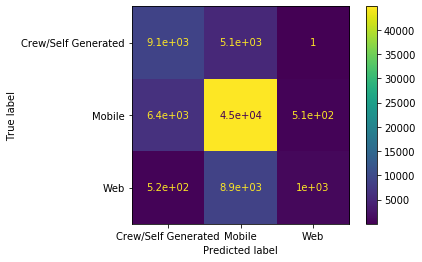

In [150]:
plot_confusion_matrix(clf, train,trainDf['case_origin'])

## Test set performance

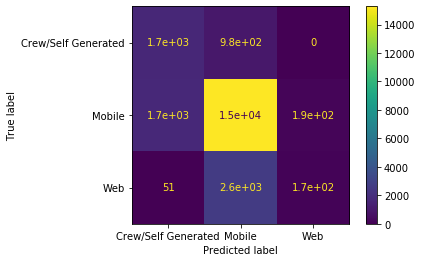

In [151]:
plot_confusion_matrix(clf, test,testDf['case_origin'])

## Goal: Likelihood!

Identify the rows where the classifier does the worst. Hopefully that will help identify data issues.

This code is bad - I ran out of time.

array([0.3889784 , 0.54523866, 0.06578293])

In [159]:
case_origin = list(testDf['case_origin'])

classDict = {}
for ii in range(len(clf.classes_)):
    classDict[clf.classes_[ii]] = ii 

caseIndex = []
for caseName in case_origin:
    caseIndex.append(classDict[caseName])

In [173]:
# Next step: grab probability for each using the index
# Then sort to find those with the lowest value (most surprise)

clf.predict_proba(train)